# Differentiable Shallow Water Equations

We present a differentiable SWE solver, based on `torch-harmonics`. 

In [14]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
cmap = 'twilight_shifted'

from math import ceil, floor

import sys
sys.path.append("../torch_harmonics")
sys.path.append("../examples")

from torch_harmonics.sht import *
from shallow_water_equations import *

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

We define a shallow water solver class in `shallow_water_equations.py`

In [3]:
# initialize parameters:
nlat = 512
nlon = 2*nlat
lmax = ceil(512/3)
mmax = lmax
# timestepping
dt = 50
maxiter = 12*int(86400/dt)

# initialize solver class
swe_solver = ShallowWaterSolver(nlat, nlon, dt, lmax=lmax, mmax=mmax).to(device)

lons = swe_solver.lons
lats = swe_solver.lats

jj, ii = torch.triu_indices(lmax, mmax)


In [4]:
uspec0 = swe_solver.galewsky_initial_condition()
# uspec0 = swe_solver.random_initial_condition()
    

/home/bbonev/.local/lib/python3.10/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


We are now ready to run the simulation. To perform integration in time, we will use third-order Adams-Bashforth. As we are currently not interested in gradients, we can wrap the function in `torch.inference_mode()`.

In [5]:
dudtspec = torch.zeros(3, 3, swe_solver.lmax, swe_solver.mmax, dtype=torch.complex128, device=device)
inew = 0
inow = 1
iold = 2

uspec = uspec0.clone().to(device)

# save for later:
nskip = 50
utspec = torch.zeros(floor(maxiter//nskip) + 1, *uspec.shape).cdouble().to(device)

with torch.inference_mode():
    for iter in range(maxiter+1):
        t = iter*dt

        if iter % nskip == 0:
            utspec[iter//nskip] = uspec
            print(f"t={t/3600:.2f} hours")

        dudtspec[inew] = swe_solver.dudtspec(uspec)
        
        # update vort,div,phiv with third-order adams-bashforth.
        # forward euler, then 2nd-order adams-bashforth time steps to start.
        if iter == 0:
            dudtspec[inow] = dudtspec[inew]
            dudtspec[iold] = dudtspec[inew]
        elif iter == 1:
            dudtspec[iold] = dudtspec[inew]

        uspec = uspec + swe_solver.dt*( (23./12.) * dudtspec[inew] - (16./12.) * dudtspec[inow] + (5./12.) * dudtspec[iold] )

        # implicit hyperdiffusion for vort and div.
        uspec[1:] = swe_solver.hyperdiff * uspec[1:]
        # cycle through the indices
        inew = (inew - 1) % 3
        inow = (inow - 1) % 3
        iold = (iold - 1) % 3


t=0.00 hours
t=0.69 hours
t=1.39 hours
t=2.08 hours
t=2.78 hours
t=3.47 hours
t=4.17 hours
t=4.86 hours
t=5.56 hours
t=6.25 hours
t=6.94 hours
t=7.64 hours
t=8.33 hours
t=9.03 hours
t=9.72 hours
t=10.42 hours
t=11.11 hours
t=11.81 hours
t=12.50 hours
t=13.19 hours
t=13.89 hours
t=14.58 hours
t=15.28 hours
t=15.97 hours
t=16.67 hours
t=17.36 hours
t=18.06 hours
t=18.75 hours
t=19.44 hours
t=20.14 hours
t=20.83 hours
t=21.53 hours
t=22.22 hours
t=22.92 hours
t=23.61 hours
t=24.31 hours
t=25.00 hours
t=25.69 hours
t=26.39 hours
t=27.08 hours
t=27.78 hours
t=28.47 hours
t=29.17 hours
t=29.86 hours
t=30.56 hours
t=31.25 hours
t=31.94 hours
t=32.64 hours
t=33.33 hours
t=34.03 hours
t=34.72 hours
t=35.42 hours
t=36.11 hours
t=36.81 hours
t=37.50 hours
t=38.19 hours
t=38.89 hours
t=39.58 hours
t=40.28 hours
t=40.97 hours
t=41.67 hours
t=42.36 hours
t=43.06 hours
t=43.75 hours
t=44.44 hours
t=45.14 hours
t=45.83 hours
t=46.53 hours
t=47.22 hours
t=47.92 hours
t=48.61 hours
t=49.31 hours
t=50.00

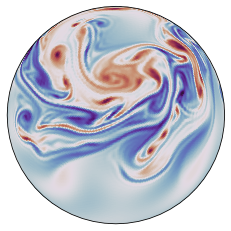

In [15]:
fig = plt.figure()
im = swe_solver.plot_specdata(uspec[1], fig, cmap=cmap, antialiased=False)
plt.show()

### Plotting a video

let us plot the vorticity for our rollout:

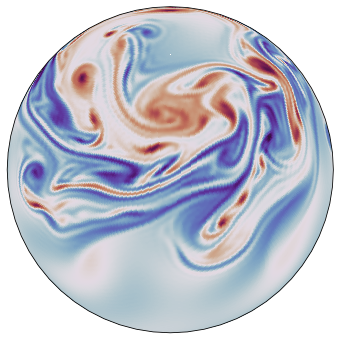

In [31]:
# prepare figure for animation
fig = plt.figure(figsize=(8, 6), dpi=72)
moviewriter = animation.writers['pillow'](fps=20)
moviewriter.setup(fig, './plots/zonal_jet.gif', dpi=72)

plot_pvrt = False

for i in range(utspec.shape[0]):
    t = i*nskip*dt

    if plot_pvrt:
        variable = swe_solver.potential_vorticity(utspec[i])
    else:
        variable = swe_solver.spec2grid(utspec[i, 1])

    plt.clf()
    # swe_solver.plot_griddata(variable, cmap=cmap, vmin=-0.2, vmax=1.8, title=f'zonal jet t={t/3600:.2f} hours')
    swe_solver.plot_griddata(variable, fig, cmap=cmap, antialiased=False)
    plt.draw()
    moviewriter.grab_frame()


moviewriter.finish()

## Conservation of potential vorticity

In [17]:
pvrttspec = torch.zeros(floor(maxiter//nskip) + 1, lmax, mmax).cdouble().to(device)
for i in range(utspec.shape[0]):
    pvrttspec[i] = swe_solver.grid2spec(swe_solver.potential_vorticity(utspec[i]))

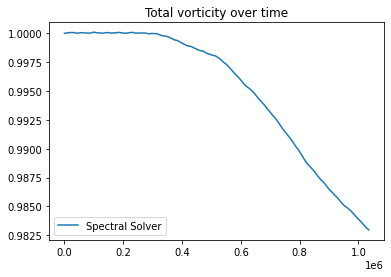

In [30]:
total_vrt = pvrttspec.abs()**2
# total_vrt = utspec[..., 1, :, :].abs()**2
total_vrt = torch.sqrt(torch.sum(total_vrt[..., :1], dim=(-1, -2)) + torch.sum(2 * total_vrt[..., 1:], dim=(-1, -2))).cpu()
t = nskip*dt * torch.arange(utspec.shape[0])

plt.plot(t, total_vrt / total_vrt[0], label='Spectral Solver')
plt.title('Total vorticity over time')
# plt.ylim((0,1))
plt.legend(loc='lower left')